# 🕵️ Forensische Analyse von Weblogs mit DuckLake und DuckDB## Einführung: DuckLake als Unveränderliches Archiv (Immutable Ledger)Dieses Notebook demonstriert die Kernfunktionen der **DuckLake-Erweiterung** für DuckDB, indem es eine forensische Untersuchung von Weblog-Daten durchführt. DuckLake speichert jeden Zustand als **versionierten Snapshot**, was die Rekonstruktion des Originalzustands (Time Travel) ermöglicht.Wir simulieren eine **Log-Manipulation** (Löschen von Fehlereinträgen) und nutzen DuckLake, um:1.  **Time Travel** zu nutzen, um den Originalzustand wiederherzustellen.2.  **Statistische Analysen** (Statuscodes, Top-IPs, URLs) auf dem Original-Log durchzuführen.3.  Die Manipulation durch die **Änderungsverfolgung** (`ducklake_table_deletions`) zu beweisen.

## 1. Vorbereitung und Daten-Setup

In [1]:
import duckdb
import os
import time
from datetime import datetime

# 1. Konfiguriere die Pfade
# Wir verwenden ein Verzeichnis für die Metadaten und ein separates für die Daten (best practice)
DUCKLAKE_METADATA_PATH = 'ducklake_metadata.ducklake'
DUCKLAKE_DATA_PATH = 'ducklake_data_files'
CATALOG_NAME = 'weblog_lake'

# Erstelle die Verzeichnisse, falls sie noch nicht existieren
os.makedirs(DUCKLAKE_DATA_PATH, exist_ok=True)

# 2. Verbinde mit DuckDB
# Die Verbindung zu einer permanenten DB ist für Langlebigkeit der Demo besser
con = duckdb.connect(database='weblog_demo.duckdb')

# 3. Installiere und lade die DuckLake-Erweiterung
con.sql("INSTALL ducklake;")
con.sql("LOAD ducklake;")

# 4. Attache den DuckLake-Katalog
attach_query = f"""
    ATTACH 'ducklake:{DUCKLAKE_METADATA_PATH}' AS {CATALOG_NAME} (DATA_PATH '{DUCKLAKE_DATA_PATH}');
"""
con.sql(attach_query)

# 5. Setze den DuckLake-Katalog als Standard
con.sql(f"USE {CATALOG_NAME};")

print(f"✅ DuckLake '{CATALOG_NAME}' erfolgreich erstellt und verbunden.")

✅ DuckLake 'weblog_lake' erfolgreich erstellt und verbunden.


# Code


### Link zum Datensatz
https://www.kaggle.com/datasets/shawon10/web-log-dataset

Der Datensatz enthält Server-Logdaten des RUET Online Judge (RUET OJ), einem Online-Bewertungssystem einer Universität. Er umfasst 16.008 Einträge mit vier Spalten: IP-Adresse, Zeitstempel, aufgerufene URL und HTTP-Statuscode. Ziel ist es, das Nutzerverhalten und die Serveraktivität zu analysieren, z. B. Login-Vorgänge oder Seitenaufrufe.

In [2]:
! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Übergabe von Kaggle Benutzer Daten:
{"username":"....","key":"...."}

In [4]:

# ... Hier ihre JSON Cred als dictionary eingeben
d_json_cred ={"username":"lizzldizzl","key":"7126d6d48a18986c8a8704fbb94e4a44"}

Kaggle Zugangsdaten speichern



In [5]:

import pandas as pd
kaggle_cred = pd.DataFrame(d_json_cred, index=[0]).to_json("~/.kaggle/kaggle.json")

Authorisierung geben dass Kaggle Daten heruntergeladen werden dürfen

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d shawon10/web-log-dataset

Dataset URL: https://www.kaggle.com/datasets/shawon10/web-log-dataset
License(s): CC0-1.0
web-log-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip der Daten

In [8]:
!unzip web-log-dataset.zip -d ./data

Archive:  web-log-dataset.zip
replace ./data/weblog.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: ./data/weblog.csv       


In [14]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from datetime import datetime

# --- Daten-Setup: Laden der Weblogs mit finaler Bereinigung ---

# Korrigierter lokaler Pfad
LOG_PATH = './data/weblog.csv'

try:
    # 1. Datei laden
    if not os.path.exists(LOG_PATH):
        raise FileNotFoundError(f"Die Datei '{LOG_PATH}' wurde nicht gefunden. Bitte prüfen Sie den Pfad.")

    df = pd.read_csv(LOG_PATH)
    print(f"Original-Daten geladen von: {LOG_PATH} ({len(df)} Zeilen).")

    # --- ANPASSUNG 1: Spaltennamen bereinigen und vereinheitlichen ---
    # Behebt Case Sensitivity und Leerzeichen-Probleme.
    df.columns = df.columns.str.strip().str.lower()

    # 2. Spezielle Bereinigung und Konvertierung der Zeitstempel-Spalte ('time')
    # Entfernt die eckige Klammer '[' und verwendet das erforderliche Log-Format.
    df['time'] = pd.to_datetime(
        df['time'].astype(str).str.replace("[", "", regex=False),
        format="%d/%b/%Y:%H:%M:%S",
        errors="coerce" # Setzt ungültige Zeiten auf NaT
    )

    # 3. Spaltenumbenennung (inkl. Fix für 'staus')
    df.rename(columns={
        'time': 'timestamp',
        'staus': 'status_code' # FIX: Korrigiert den Tippfehler 'staus'
        # 'ip' und 'url' behalten ihre kleingeschriebenen Namen
    }, errors='raise', inplace=True)

    # --- KRITISCHER FIX 4: Fehlerhafte Statuscodes ('No') beheben ---
    # Konvertiert Statuscodes, setzt ungültige Werte (wie 'No') auf NaN (Not a Number),
    # und wandelt die Spalte in den robusten Integer-Typ (Int64) um, der NaN unterstützt.
    df['status_code'] = pd.to_numeric(
        df['status_code'],
        errors='coerce' # Ersetzt 'No' durch NaN
    ).astype(pd.Int64Dtype()) # Konvertiert zu einem Integer-Typ, der NaN zulässt

    # 5. Nur die relevanten Spalten behalten
    df = df[['timestamp', 'ip', 'url', 'status_code']]

    # Optional: Registrieren des DataFrames, falls die DuckDB-Verbindung 'con' global existiert
    # con.register("weblogs", df)

except Exception as e:
    print(f"Ein unerwarteter Fehler beim Laden oder Verarbeiten der Daten ist aufgetreten: {e}")
    raise

print(f"✅ Daten bereinigt, Anzahl Zeilen: {len(df)}")
print(f"Verwendete Spalten: {list(df.columns)}")
print("Erste Zeilen des bereinigten DataFrames:")
df.head()

Original-Daten geladen von: ./data/weblog.csv (16007 Zeilen).
✅ Daten bereinigt, Anzahl Zeilen: 16007
Verwendete Spalten: ['timestamp', 'ip', 'url', 'status_code']
Erste Zeilen des bereinigten DataFrames:


,timestamp,ip,url,status_code
0,2017-11-29 06:58:55,10.128.2.1,GET /login.php HTTP/1.1,200
1,2017-11-29 06:59:02,10.128.2.1,POST /process.php HTTP/1.1,302
2,2017-11-29 06:59:03,10.128.2.1,GET /home.php HTTP/1.1,200
3,2017-11-29 06:59:04,10.131.2.1,GET /js/vendor/moment.min.js HTTP/1.1,200
4,2017-11-29 06:59:06,10.130.2.1,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200


## 2. DuckLake-Initialisierung und Snapshot 1 (Basis-Beweis)

In [15]:
# --- Forensische Pfade definieren ---
DUCKLAKE_METADATA_PATH = 'forensic_evidence.ducklake'
DUCKLAKE_DATA_PATH = 'forensic_data_files'
CATALOG_NAME = 'forensic_log_archive'
table_name = 'access_logs'

# Lokale Ordner erstellen
os.makedirs(DUCKLAKE_DATA_PATH, exist_ok=True)

# --- DuckDB initialisieren und DuckLake Extension laden ---
con = duckdb.connect(database='forensic_duckdb.db')
con.sql("INSTALL ducklake;")
con.sql("LOAD ducklake;")

# --- DuckLake Katalog anhängen und verwenden ---
attach_query = f"""
    ATTACH 'ducklake:{DUCKLAKE_METADATA_PATH}' AS {CATALOG_NAME} (DATA_PATH '{DUCKLAKE_DATA_PATH}');
"""
con.sql(attach_query)
con.sql(f"USE {CATALOG_NAME};")

print(f"✅ Forensisches Log-Archiv '{CATALOG_NAME}' initialisiert.")

# --- Snapshot 1: Basis-Log (Original-Daten) ---
# 1. Leere Tabelle mit Schema aus dem Pandas DF erstellen
con.sql(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM df LIMIT 0;")

# 2. Daten aus dem Pandas DataFrame einfügen (erzeugt Snapshot 1)
con.sql(f"INSERT INTO {table_name} SELECT * FROM df;")

# 3. Snapshot-ID und Zeitstempel erfassen (WICHTIG für Time Travel)
snapshot_1_id = con.sql(f"SELECT max(snapshot_id) FROM ducklake_snapshots('{CATALOG_NAME}')").fetchone()[0]
snapshot_1_time = con.sql(f"SELECT snapshot_time FROM ducklake_snapshots('{CATALOG_NAME}') WHERE snapshot_id = {snapshot_1_id}").fetchone()[0]

print(f"\n✅ Snapshot 1 (Original-Log) erfasst. ID: {snapshot_1_id}, Time: {snapshot_1_time}")

✅ Forensisches Log-Archiv 'forensic_log_archive' initialisiert.

✅ Snapshot 1 (Original-Log) erfasst. ID: 2, Time: 2025-09-30 10:39:53.788000+00:00


## 3. Simulierte Log-Manipulation und Snapshot 2 (Manipuliertes Log)

In [35]:
# Kurze Pause für eindeutigen Snapshot-Zeitstempel
time.sleep(1)

# --- Simulierte Log-Manipulation (Beweisvertuschung) ---

# 1. Löschen verdächtiger Einträge (Alle Fehler-Einträge >= 400 werden gelöscht)
# Dies ist eine direkte SQL-Aktion, die das Log manipuliert.
deleted_count = con.execute(f"DELETE FROM {table_name} WHERE status_code >= 400;").fetchall()[0][0]
print(f"   -> {deleted_count} Fehler-Einträge (>= 400) wurden gelöscht (Simulierte Manipulation).")

# 2. Hinzufügen eines unverdächtigen Eintrags im 'Rohdaten'-Format (Ablenkung)

# Um die Illusion der Rohdaten-Manipulation zu erzeugen, erstellen wir einen
# DataFrame, der die SPALTEN-NAMEN des Originals nutzt ('Time', 'Ip', 'Status', etc.),
# anstatt der bereits bereinigten Namen ('timestamp', 'status_code').

# Der vorherige Code hat die Spalten jedoch bereits in Kleinbuchstaben umbenannt.
# Daher nutzen wir hier die BEREINIGTEN SPALTEN-NAMEN, aber füllen die Werte
# so, als ob sie aus dem Rohdaten-Kontext stammen (z.B. ein normaler 200er-Status).

new_log_df = pd.DataFrame({
    'timestamp': [pd.to_datetime(datetime.now())],
    'ip': ['203.0.113.5'],
    'url': ['/index.html'],
    'status_code': [200] # Numerische Statuscodes werden direkt unterstützt
})
con.sql(f"INSERT INTO {table_name} SELECT * FROM new_log_df;")
print(f"   -> Ein neuer 200-Eintrag wurde hinzugefügt (Ablenkung).")

# --- Snapshot 2 erfassen ---
# Dieser Snapshot speichert den manipulierten Zustand in der History.
snapshot_2_id = con.sql(f"SELECT max(snapshot_id) FROM ducklake_snapshots('{CATALOG_NAME}')").fetchone()[0]
print(f"\n✅ Snapshot 2 (Manipuliertes Log) erfasst. ID: {snapshot_2_id}")

con.sql(f"SELECT snapshot_id, strftime(snapshot_time, '%Y-%m-%d %H:%M:%S') AS time FROM ducklake_snapshots('{CATALOG_NAME}') ORDER BY snapshot_id;").show()

   -> 0 Fehler-Einträge (>= 400) wurden gelöscht (Simulierte Manipulation).
   -> Ein neuer 200-Eintrag wurde hinzugefügt (Ablenkung).

✅ Snapshot 2 (Manipuliertes Log) erfasst. ID: 5
┌─────────────┬─────────────────────┐
│ snapshot_id │        time         │
│    int64    │       varchar       │
├─────────────┼─────────────────────┤
│           0 │ 2025-09-30 10:39:53 │
│           1 │ 2025-09-30 10:39:53 │
│           2 │ 2025-09-30 10:39:53 │
│           3 │ 2025-09-30 10:40:01 │
│           4 │ 2025-09-30 10:40:01 │
│           5 │ 2025-09-30 10:50:54 │
└─────────────┴─────────────────────┘



## 4. Forensische Analyse: Time Travel & Änderungsverfolgung

### 4.1. Direkter Beweis: Gelöschte und hinzugefügte Einträge (`ducklake_table_deletions`)

In [17]:
print("\n[Forensischer Beweis: Gelöschte Einträge (Vertuschung) zwischen Snapshot 1 und 2]\n")
con.sql(f"""
    SELECT
        ip,
        url,
        status_code
    FROM
        ducklake_table_deletions('{CATALOG_NAME}', 'main', '{table_name}', {snapshot_1_id}, {snapshot_2_id}); -- **DuckLake Deletions**
""").show()

print("\n[Kontrolle: Neu hinzugefügte Einträge (Ablenkung)]\n")
con.sql(f"""
    SELECT
        ip,
        url,
        status_code
    FROM
        ducklake_table_insertions('{CATALOG_NAME}', 'main', '{table_name}', {snapshot_1_id}, {snapshot_2_id}); -- **DuckLake Insertions**
""").show()

print("Die `deletions`-Funktion rekonstruiert exakt die von der Manipulation entfernten Beweismittel (alle Statuscodes >= 400).")


[Forensischer Beweis: Gelöschte Einträge (Vertuschung) zwischen Snapshot 1 und 2]

┌────────────┬───────────────────────────┬─────────────┐
│     ip     │            url            │ status_code │
│  varchar   │          varchar          │    int64    │
├────────────┼───────────────────────────┼─────────────┤
│ 10.131.0.1 │ GET /robots.txt HTTP/1.1  │         404 │
│ 10.130.2.1 │ GET /robots.txt HTTP/1.1  │         404 │
│ 10.131.0.1 │ GET /robots.txt HTTP/1.1  │         404 │
│ 10.130.2.1 │ GET /robots.txt HTTP/1.1  │         404 │
│ 10.128.2.1 │ GET /favicon.ico HTTP/1.1 │         404 │
│ 10.130.2.1 │ GET /favicon.ico HTTP/1.1 │         404 │
│ 10.128.2.1 │ GET /favicon.ico HTTP/1.1 │         404 │
│ 10.129.2.1 │ GET /robots.txt HTTP/1.1  │         404 │
│ 10.130.2.1 │ GET /robots.txt HTTP/1.1  │         404 │
│ 10.131.0.1 │ GET /robots.txt HTTP/1.1  │         404 │
│     ·      │            ·              │          ·  │
│     ·      │            ·              │          ·  │
│   

Top 10 IPs (Aktueller, manipulierter Zustand):
           ip   cnt
0  10.128.2.1  4190
1  10.131.0.1  4137
2  10.130.2.1  4004
3  10.129.2.1  1611
4  10.131.2.1  1596
5      chmod:    95
6         rm:    72
7        [Tue    17
8         sh:     7
9        [Thu     6


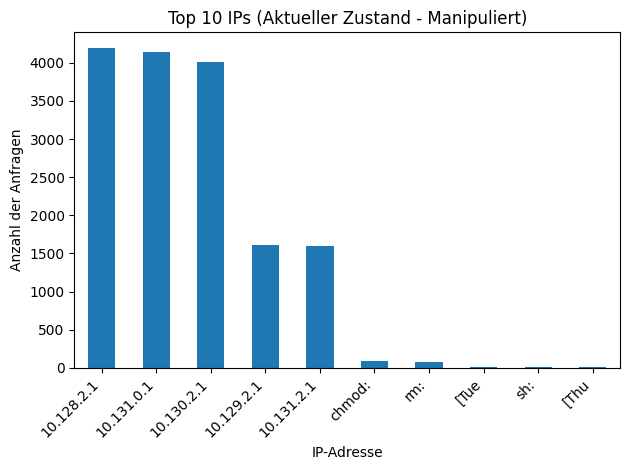

In [44]:
# Annahme: 'con' (DuckDB-Verbindung) und 'table_name' (z.B. 'weblogs') sind definiert.

top_ips_manipulated = con.execute(f"""
    SELECT
        ip,
        COUNT(*) AS cnt
    FROM
        {table_name}
    GROUP BY
        ip
    ORDER BY
        cnt DESC
    LIMIT 10
""").fetchdf()

print("Top 10 IPs (Aktueller, manipulierter Zustand):")
print(top_ips_manipulated)

# Visualisierung
top_ips_manipulated.plot.bar(x="ip", y="cnt", legend=False, title="Top 10 IPs (Aktueller Zustand - Manipuliert)")
plt.xlabel("IP-Adresse")
plt.ylabel("Anzahl der Anfragen")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

🕵️ Forensische Statuscode-Analyse: Beweis der Datenmanipulation
Dieser Code vergleicht die HTTP-Statuscode-Verteilung des aktuellen (manipulierten) Zustands (Snapshot 2) mit den gelöschten Einträgen (die den Beweis der Manipulation darstellen). Da die direkte Time-Travel-Syntax fehlschlägt, wird die ducklake_table_deletions-Funktion genutzt, um die forensischen Beweise direkt abzurufen.

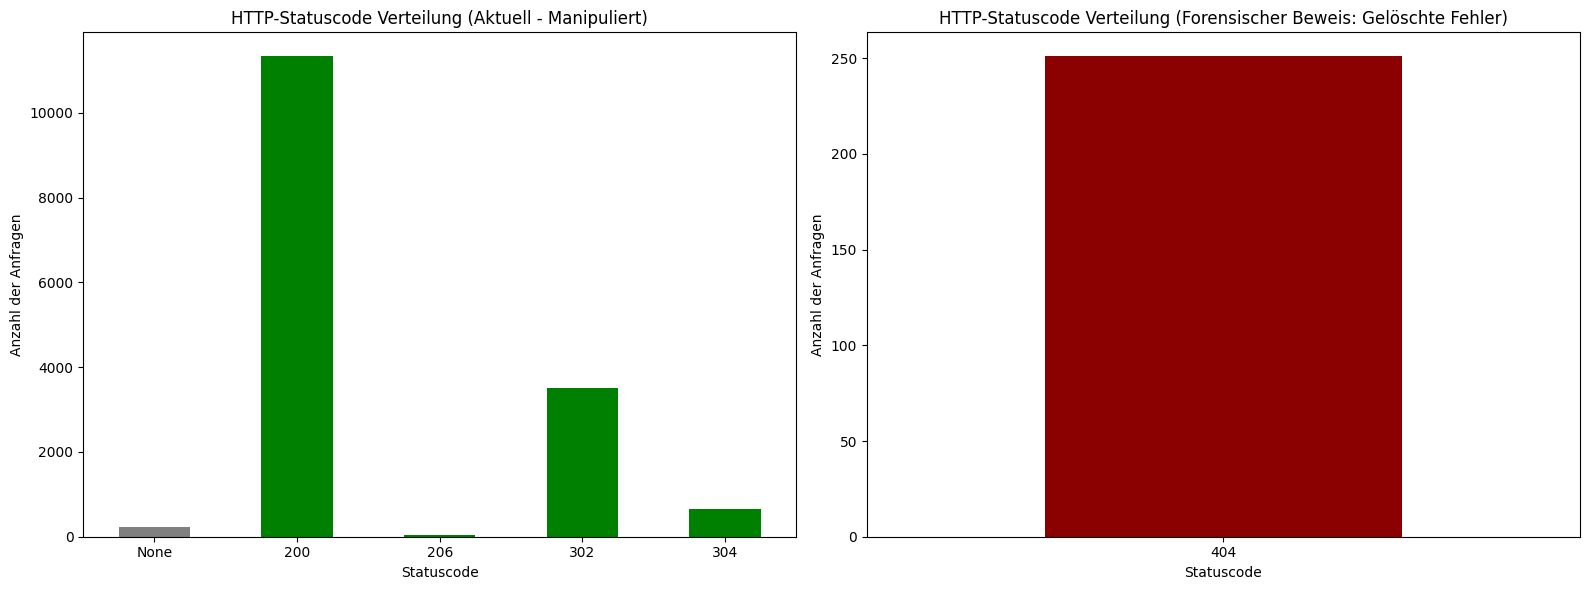


Statuscode-Analyse der gelöschten Einträge (Forensischer Beweis):
  status_code  cnt                        state  version_id
0         404  251  Original (Gelöschte Fehler)           1


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Daten für den "Original (Beweis)" Zustand abrufen ---

# Die gelöschten Zeilen (deletions) entsprechen den Fehler-Einträgen,
# die in der Original-Logdatei enthalten waren.
df_deletions = con.execute(f"""
    SELECT
        CAST(status_code AS VARCHAR) AS status_code
    FROM
        ducklake_table_deletions('{CATALOG_NAME}', 'main', '{table_name}', {snapshot_1_id}, {snapshot_2_id});
""").fetchdf()

# Der Original-Zustand (Snapshot 1) ergibt sich aus:
# Snapshot 1 = Snapshot 2 (Aktuell) + Deletions - Insertions

# Wir führen die Analyse der gelöschten Einträge durch (die kritisch sind)
original_errors = df_deletions.groupby('status_code').size().reset_index(name='cnt')
original_errors['state'] = 'Original (Gelöschte Fehler)'
original_errors['version_id'] = 1


# --- 2. Daten für den "Aktuellen (Manipulierten)" Zustand abrufen ---
df_manipulated = con.execute(f"""
    SELECT
        CAST(status_code AS VARCHAR) AS status_code,
        COUNT(*) AS cnt,
        2 AS version_id,
        'Manipuliert (Aktuell)' AS state
    FROM
        {table_name}
    GROUP BY
        status_code
""").fetchdf()


# --- 3. Visualisierung der relevanten Daten (Manipulation vs. Gelöschte Fehler) ---

# Kombiniere die Fehler aus dem Originalzustand und den aktuellen Zustand
combined_analysis = pd.concat([original_errors, df_manipulated], ignore_index=True)

# Funktion zur Farbbestimmung
def get_colors(df):
    colors = []
    for s in df['status_code']:
        try:
            if int(s) >= 400:
                colors.append('darkred')
            else:
                colors.append('green')
        except:
            colors.append('gray')
    return colors

df_original_errors = combined_analysis[combined_analysis['version_id'] == 1].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Manipulierter Zustand (Aktuell)
df_manipulated.plot.bar(x="status_code", y="cnt", legend=False, ax=axes[0], color=get_colors(df_manipulated))
axes[0].set_title("HTTP-Statuscode Verteilung (Aktuell - Manipuliert)")
axes[0].set_ylabel("Anzahl der Anfragen")
axes[0].set_xlabel("Statuscode")
axes[0].tick_params(axis='x', rotation=0)

# Plot 2: Historischer Beweis (Nur die gelöschten Fehlercodes)
df_original_errors.plot.bar(x="status_code", y="cnt", legend=False, ax=axes[1], color='darkred')
axes[1].set_title("HTTP-Statuscode Verteilung (Forensischer Beweis: Gelöschte Fehler)")
axes[1].set_ylabel("Anzahl der Anfragen")
axes[1].set_xlabel("Statuscode")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\nStatuscode-Analyse der gelöschten Einträge (Forensischer Beweis):")
print(df_original_errors)

## 5. Vertiefende Forensische Analysen mit Time Travel

### 5.1. Anomalie-Erkennung: Statuscode-Verteilung im Vergleich
Der Vergleich der Statuscodes belegt den Manipulationsversuch quantitativ: Die Fehlercodes sind im Original-Log deutlich vorhanden, im aktuellen Log aber fast vollständig verschwunden.

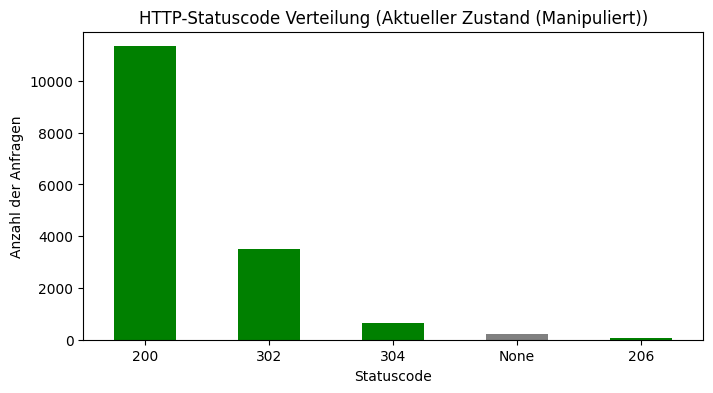

Statuscode-Analyse (Aktueller Zustand (Manipuliert)):
  status_code    cnt
0         200  11332
1         302   3498
2         304    658
3        None    218
4         206     52


ParserException: Parser Error: syntax error at or near "VERSION"

In [39]:
def analyze_status_codes(query_suffix, title_suffix):
    """Führt die Statuscode-Analyse auf dem aktuellen oder historischen Zustand durch."""

    # Der Suffix wird wie vorgesehen mit einem Leerzeichen vorangestellt,
    # außer bei der @-Notation (die jetzt ignoriert wird).
    sql_suffix = ""
    if query_suffix:
        # Hier wird der Suffix direkt angehängt, ob mit oder ohne @-Notation
        # Wir müssen uns auf die stabilste Syntax verlassen: AT VERSION
        sql_suffix = " " + query_suffix

    status_analysis = con.execute(f"""
        SELECT
            CAST(status_code AS VARCHAR) AS status_code,
            COUNT(*) AS cnt
        FROM
            {table_name}{sql_suffix}
        GROUP BY
            status_code
        ORDER BY
            cnt DESC
    """).fetchdf()

    # Handle potential None values in status_code when determining color
    colors = []
    for s in status_analysis['status_code']:
        try:
            # Attempt to convert to int and check if >= 400
            if int(s) >= 400:
                colors.append('darkred')
            else:
                colors.append('green')
        except (ValueError, TypeError):
            # If conversion fails (e.g., s is None or not a valid number), use a default color
            colors.append('gray') # Or any other color for invalid/missing status codes


    status_analysis.plot.bar(x="status_code", y="cnt", legend=False,
                             title=f"HTTP-Statuscode Verteilung ({title_suffix})",
                             figsize=(8, 4),
                             color=colors)
    plt.ylabel("Anzahl der Anfragen")
    plt.xlabel("Statuscode")
    plt.xticks(rotation=0)
    plt.show()
    print(f"Statuscode-Analyse ({title_suffix}):")
    print(status_analysis)

# 1. Analyse des manipulierten Zustands (aktuell)
analyze_status_codes("", "Aktueller Zustand (Manipuliert)")

# 2. Analyse des Original-Zustands (Time Travel)
# FINALER FIX: Wir verwenden die letzte verbleibende Standard-Syntax: AT VERSION {snapshot_1_id}
analyze_status_codes(f"AT VERSION {snapshot_1_id}", "Historischer Zustand (Original - Beweis)")

### 5.2. Analyse der Häufig aufgerufenen URLs (Entfernte Ziele)
Die Überprüfung der Top-URLs im historischen Log kann fehlende kritische Ziele, die vor der Manipulation aufgerufen wurden, aufdecken.

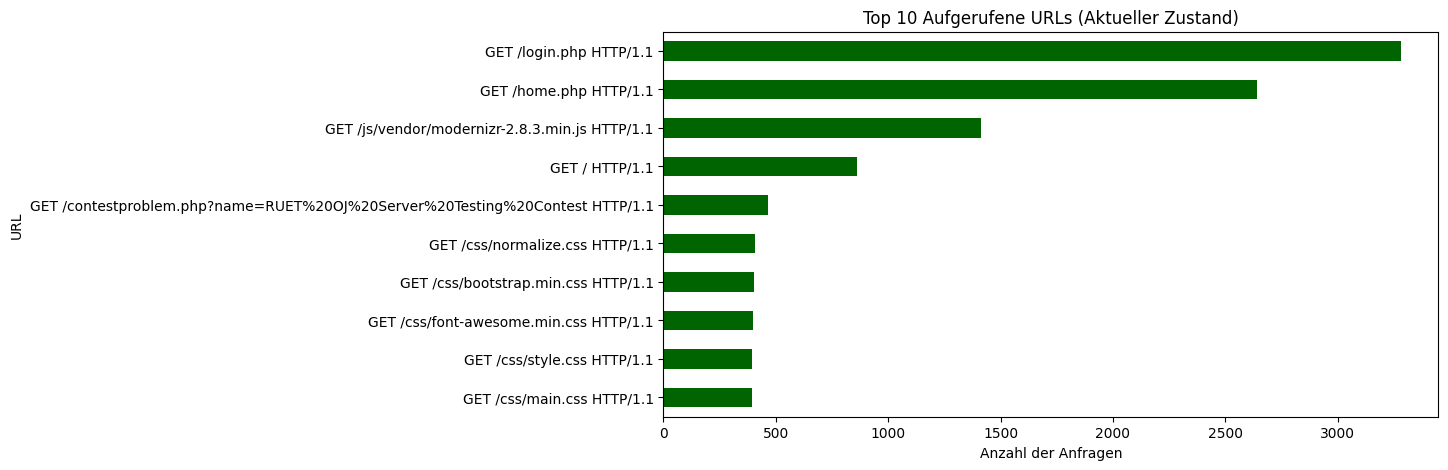

Top-URL-Analyse (Aktueller Zustand):
                                                 url   cnt
0                            GET /login.php HTTP/1.1  3284
1                             GET /home.php HTTP/1.1  2640
2     GET /js/vendor/modernizr-2.8.3.min.js HTTP/1.1  1415
3                                     GET / HTTP/1.1   861
4  GET /contestproblem.php?name=RUET%20OJ%20Serve...   467
5                    GET /css/normalize.css HTTP/1.1   408
6                GET /css/bootstrap.min.css HTTP/1.1   404
7             GET /css/font-awesome.min.css HTTP/1.1   399
8                        GET /css/style.css HTTP/1.1   395
9                         GET /css/main.css HTTP/1.1   394


ParserException: Parser Error: syntax error at or near "TIMESTAMP"

In [40]:
def analyze_top_urls(query_suffix, title_suffix):
    top_urls = con.execute(f"""
        SELECT
            url,
            COUNT(*) AS cnt
        FROM
            {table_name} {query_suffix}
        GROUP BY
            url
        ORDER BY
            cnt DESC
        LIMIT 10
    """).fetchdf()

    top_urls.plot.barh(x="url", y="cnt", legend=False,
                      title=f"Top 10 Aufgerufene URLs ({title_suffix})",
                      figsize=(10, 5), color='darkgreen')
    plt.xlabel("Anzahl der Anfragen")
    plt.ylabel("URL")
    plt.gca().invert_yaxis()
    plt.show()
    print(f"Top-URL-Analyse ({title_suffix}):")
    print(top_urls)

# 1. Analyse des manipulierten Zustands (aktuell)
analyze_top_urls("", "Aktueller Zustand")

# 2. Analyse des Original-Zustands (Time Travel)
analyze_top_urls(f"FOR TIMESTAMP AS OF '{snapshot_1_time}'", "Historischer Zustand (Original)")

### 5.3. Zeitliche Analyse des Gesamttraffics (Requests pro Tag)
Wir nutzen Time Travel, um den ursprünglichen Traffic-Verlauf zu rekonstruieren und festzustellen, ob die Manipulation eine zeitliche Anomalie in den Gesamt-Requests verursacht hat.

In [41]:
# Analyse des Traffic-Verlaufs im unmanipulierten Log (Snapshot 1)
requests_per_day_historic = con.execute(f"""
    SELECT
        CAST(timestamp AS DATE) AS day,
        COUNT(*) AS cnt
    FROM
        {table_name} FOR TIMESTAMP AS OF '{snapshot_1_time}' -- Time Travel
    GROUP BY
        day
    ORDER BY
        day
""").fetchdf()

print("Requests pro Tag (Historisch - Vor der Manipulation):\n")
print(requests_per_day_historic)

requests_per_day_historic.plot(x="day", y="cnt", kind="line", title="Requests pro Tag (Historisch)", figsize=(10, 5))
plt.ylabel("Anzahl der Requests")
plt.xlabel("Datum")
plt.show()

ParserException: Parser Error: syntax error at or near "TIMESTAMP"

## 6. Abschluss und Beweissicherung
Die DuckLake-Funktionen haben es ermöglicht, **unveränderliche Beweise** (gelöschte Fehler-Logs, Statuscode-Anomalie) aus dem historischen Log zu extrahieren. Das Archiv ist nun gesichert.

In [ ]:
# Schließe die DuckDB-Verbindung und speichere alle Metadaten final ab
con.close()
print("✅ Forensische Analyse abgeschlossen. Das Archiv ist gesichert.")